In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint

sys.path.append("..")
from tfbs_check.modules import CNNModule as torch_module
from tfbs_check.dataset import TFBSDataset
from tfbs_check.helper import Helper

import seqlogo

In [2]:
helper_class = Helper()
helper_class.add_variable("model", "../tfbs_check_nonjaspar/results/model.pt")
helper_class.add_variable("binary", False)
helper_class.add_variable("kernel_size", 15)
helper_class.add_variable("num_filters", 1)
helper_class.add_variable("stride", 1)
helper_class.add_variable("padding", 0)

if helper_class.get_variable("padding") >= helper_class.get_variable("kernel_size"):
    raise Exception("Invalid padding")
    
if helper_class.get_variable("stride") > helper_class.get_variable("kernel_size"):
    raise Exception("Invalid stride")

In [3]:
helper_class.add_variable("promoters", "../../{0}".format(Helper.PROMOTER_FILE))
helper_class.add_variable("non-promoters", "../../{0}".format(Helper.NONPROMOTER_FILE))
promoter_path = os.path.abspath(helper_class.get_variable("promoters"))
nonpromoter_path = os.path.abspath(helper_class.get_variable("non-promoters"))

ds = TFBSDataset(file=promoter_path, neg_file=nonpromoter_path, binary=False, save_df=False)
helper_class.add_variable("length", ds.seqs_length)

True

In [4]:
def analyse_aggregated_weights(title, helper_class, filter_weights, aggregate_function, weights1=None, weights2=None):
    print(title)
    all_filter_weights = []
    p_ = helper_class.get_variable("padding")
    s_ = helper_class.get_variable("stride")
    for idx, w in enumerate(filter_weights):
        combined_weights = np.zeros((len(helper_class.get_DNA_dict()),helper_class.get_variable("length")))
        conv_result_length = len(weights1) // len(filter_weights)
        for position in range(conv_result_length):
            balanced_weights = aggregate_function(idx, w, position, conv_result_length, weights1, weights2)
            cw_start = Helper.relu((position*s_)-p_)
            cw_end = Helper.neg_relu((position*s_)-p_+w.shape[1], combined_weights.shape[1])
            bw_start = Helper.relu(p_-position)
            buffer = conv_result_length-position
            bw_end = buffer if buffer <= p_ else w.shape[1]
            #print('%s %s - %s %s' %(cw_start, cw_end, bw_start, bw_end))
            combined_weights[:,cw_start:cw_end] += balanced_weights[:,bw_start:bw_end]
        all_filter_weights.append(combined_weights)
    combined_filter_weights = np.zeros((len(helper_class.get_DNA_dict()),helper_class.get_variable("length")))
    for ws in all_filter_weights:
        combined_filter_weights += ws
        weights = Helper.softmax(ws)
        ppm = weights.T
        ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
        display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'xxxlarge'))

    print("Combined filters")
    weights = Helper.softmax(combined_filter_weights)
    ppm = weights.T
    ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
    display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'xxxlarge'))

In [5]:
fullpath = os.path.abspath(helper_class.get_variable("model"))
model_folder = os.path.dirname(fullpath)
cp = Checkpoint(dirname=model_folder, f_params=os.path.basename(fullpath))
# Binary(sigmoid): Use NeuralNetBinaryClassifier, num_classes=1, criterion=BCEWithLogitsLoss, binary=True
# Multi(softmax): Use NeuralNetClassifier, num_classes=2, criterion=CrossEntropyLoss, binary=False
    
net = NeuralNetClassifier(module=torch_module,
                          module__num_classes=1 if helper_class.get_variable("binary") else 2,
                          module__seqs_length=helper_class.get_variable("length"),
                          module__kernel_size=helper_class.get_variable("kernel_size"),
                          module__num_filters=helper_class.get_variable("num_filters"),
                          module__stride=helper_class.get_variable("stride"),
                          module__padding=helper_class.get_variable("padding"))
net.initialize()
print("Network Initialized")
net.load_params(checkpoint=cp)
print("Model Loaded")

Network Initialized
Model Loaded


In [6]:
print("Detaching weights from network")
output_weights = net.module_.out.weight.detach().numpy().astype(float)
promoter_weights = output_weights[helper_class.get_LABEL_dict()['Promoter']]
non_promoter_weights = output_weights[helper_class.get_LABEL_dict()['Non-Promoter']]
if (len(promoter_weights) != len(non_promoter_weights)):
    raise Exception("Something is wrong with the weights")

filter_weights = np.squeeze(net.module_.conv.weight.detach().numpy().astype(float))
if filter_weights.ndim < 3:
    filter_weights = np.expand_dims(filter_weights, axis=0)

Detaching weights from network


Analyzing filter weights


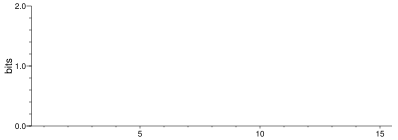

In [7]:
print("Analyzing filter weights")
for w in filter_weights:
    weights = Helper.softmax(w)
    ppm = weights.T
    ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
    display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'medium'))

Analyzing reciprocal filter weights


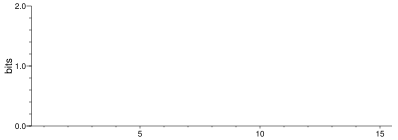

In [8]:
print("Analyzing reciprocal filter weights")
for w in filter_weights:
    weights = Helper.softmax(w)
    ppm = Helper.reciprocal(weights).T
    ppm_logo = seqlogo.Ppm(Helper.sum_one(ppm))
    display(seqlogo.seqlogo(ppm_logo, ic_scale = True, format = 'svg', size = 'medium'))

Analyzing promoter weights - non-promoter weights


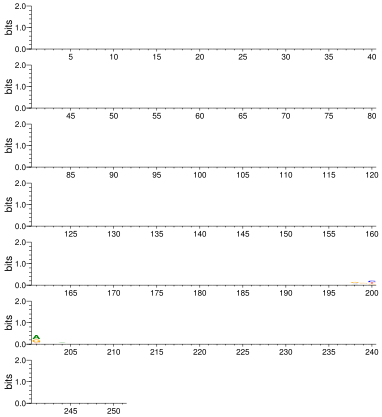

Combined filters


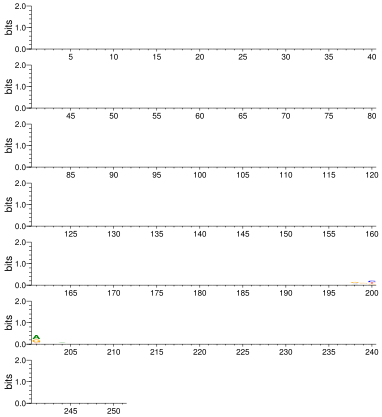

In [9]:
title = "Analyzing promoter weights - non-promoter weights"
analyse_aggregated_weights(title, helper_class, filter_weights, Helper.aggregate_weights, promoter_weights, non_promoter_weights)

Analyzing non-promoter weights - promoter weights


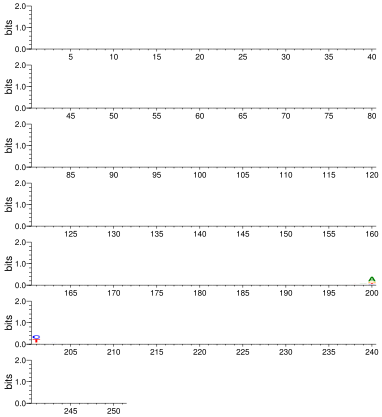

Combined filters


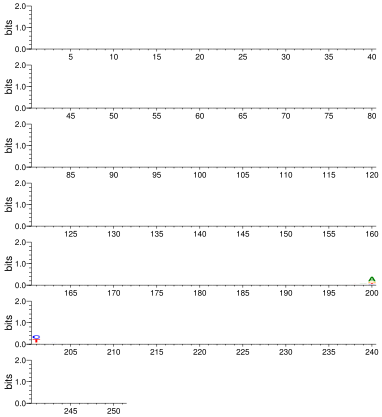

In [10]:
title = "Analyzing non-promoter weights - promoter weights"
analyse_aggregated_weights(title, helper_class, filter_weights, Helper.aggregate_weights, non_promoter_weights, promoter_weights)

Analyzing promoter weights


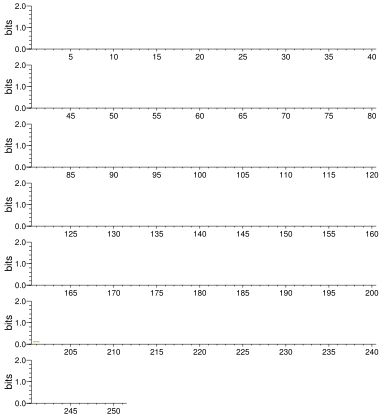

Combined filters


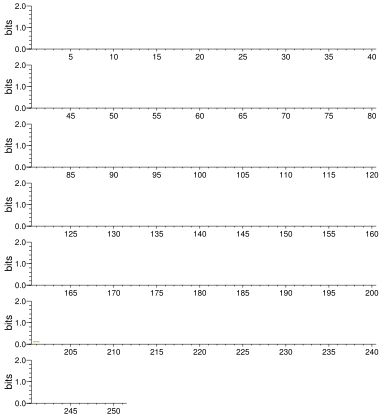

In [11]:
title = "Analyzing promoter weights"
analyse_aggregated_weights(title, helper_class, filter_weights, Helper.aggregate_weights, weights1=promoter_weights)

Analyzing non-promoter weights


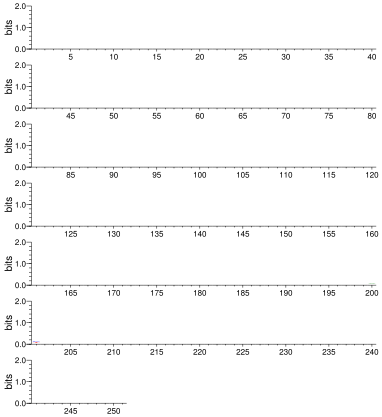

Combined filters


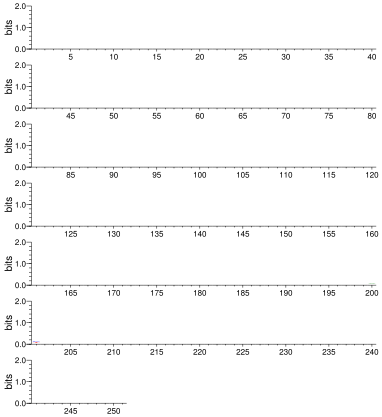

In [12]:
title = "Analyzing non-promoter weights"
analyse_aggregated_weights(title, helper_class, filter_weights, Helper.aggregate_weights, weights1=non_promoter_weights)